In [2]:
import pandas as pd
from pathlib import Path
from tennis_new.fetch.defs import STORED_DATA_PATH

jd = pd.read_csv(
    Path.joinpath(STORED_DATA_PATH, 'joined.tsv'),
    parse_dates=['tourney_start_date'],
    sep='\t'
)

/Users/siddhantjagadish/Documents/DataProjects/tennis_new/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (7,8,13,33,39,40,41,42,43,44,45,46) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
jd['tourney_surface'].value_counts()

Hard      76802
Clay      65213
Grass     38456
Carpet    17635
Name: tourney_surface, dtype: int64

In [6]:
# We should know surface for all matches
assert jd['tourney_surface'].notnull().all()

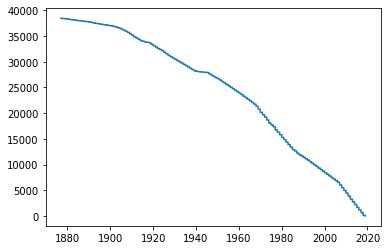

In [7]:
# How much grass data do we have over time?
%matplotlib inline
from matplotlib import pyplot as plt

plt.plot(
    jd['tourney_year'],
    (jd['tourney_surface'] == 'Grass').sum() - (jd['tourney_surface'] == 'Grass').cumsum()
)

In [8]:
# Say we want 5k grass test set matches, let's get these...
# TODO: Put in repo with unittests?
import numpy as np

TEST_SIZE = 5000

def get_val_test_for_surface(df, surface='Grass', n=5000):
    total_on_surface = (df['tourney_surface'] == surface).sum()
    n_test_on_surface = total_on_surface - (df['tourney_surface'] == surface).cumsum()
    val_idx = np.where(
        (n_test_on_surface <= 2 * n) &
        (n_test_on_surface > n) &
        (df['tourney_surface'] == surface)
    )[0]
    test_idx = np.where(
        (n_test_on_surface <= n) &
        (df['tourney_surface'] == surface)
    )[0]
    return val_idx, test_idx 

In [9]:
val_idx, test_idx = get_val_test_for_surface(jd, surface='Grass')

In [10]:
len(val_idx), len(test_idx)

(5000, 5001)

In [11]:
jd[['tourney_year', 'tourney_month']].iloc[[val_idx.min(), test_idx.min()], :]

,tourney_year,tourney_month
108773,1995,6
155866,2009,7


My validation set begins in June 1995 and my test begins in July 2009

In [12]:
# Universal ELO Model
from tennis_new.ml.elo import ELOModel

elo = ELOModel(winner_mod=True)
elo.fit_and_backfill(
    jd['winner_name'].tolist(),
    jd['loser_name'].tolist(),
    jd['match_id'].tolist()
)

In [13]:
def _eval_mod(mod):
    history_df = pd.DataFrame(mod.history)
    val_accuracy = (history_df.iloc[val_idx]['elo_match_prediction'] > 0.5).mean()
    test_accuracy = (history_df.iloc[test_idx]['elo_match_prediction'] > 0.5).mean()
    return {
        'val_accuracy': val_accuracy,
        'test_accuracy': test_accuracy
    }

In [14]:
_eval_mod(elo)

{'val_accuracy': 0.6604, 'test_accuracy': 0.6600679864027195}

Without any surface weighting, we achieve 66% accuracy on both the val set and the test set.  Now let's try surface weighting... 

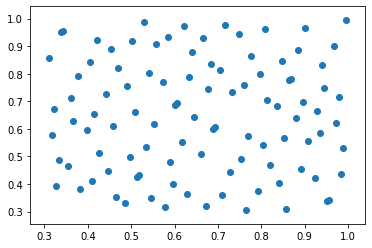

In [15]:
# Sobol functions... 
# TODO: These should be in the repo
from tennis_new.ml.sobol import generate_sobol_seq, get_range_values 


N_MODELS = 100
SEED = 10
MIN_WEIGHT = 0.3
MAX_WEIGHT = 1.

sobol_grid = generate_sobol_seq(3, N_MODELS, SEED)
clay_weights = get_range_values(MIN_WEIGHT, MAX_WEIGHT, sobol_grid[:, 0])
hard_weights = get_range_values(MIN_WEIGHT, MAX_WEIGHT, sobol_grid[:, 1])
carpet_weights = get_range_values(MIN_WEIGHT, MAX_WEIGHT, sobol_grid[:, 2])

plt.scatter(clay_weights, hard_weights)

In [16]:
# Tune over surface weights
from tqdm import tqdm

out = []
for clay, hard, carpet in tqdm(zip(clay_weights, hard_weights, carpet_weights)):
    weight_dict = {
        'Clay': clay,
        'Hard': hard,
        'Carpet': carpet,
        'Grass': 1.0
    }
    weights = jd['tourney_surface'].map(lambda x: weight_dict[x])
    cur_elo = ELOModel(winner_mod=True)
    cur_elo.fit_and_backfill(
        jd['winner_name'].tolist(),
        jd['loser_name'].tolist(),
        jd['match_id'].tolist(),
        weights=weights
    )
    cur_eval = _eval_mod(cur_elo)
    cur_eval.update(weight_dict)
    out.append(cur_eval)

100it [02:03,  1.24s/it]


In [17]:
tune_df = pd.DataFrame(out)
tune_df.sort_values('val_accuracy', ascending=False).head(20)

,Carpet,Clay,Grass,Hard,test_accuracy,val_accuracy
69,0.830469,0.360156,1.0,0.710156,0.665267,0.6666
54,0.611719,0.316406,1.0,0.578906,0.663467,0.6664
21,0.584375,0.321875,1.0,0.671875,0.665467,0.6658
6,0.890625,0.365625,1.0,0.628125,0.664267,0.6654
86,0.950781,0.327344,1.0,0.392969,0.662667,0.6648
45,0.748437,0.442187,1.0,0.726562,0.665267,0.6648
34,0.595312,0.551562,1.0,0.617188,0.662667,0.6644
66,0.655469,0.535156,1.0,0.535156,0.657668,0.6640
37,0.420312,0.376562,1.0,0.792187,0.663667,0.6640
53,0.967187,0.310937,1.0,0.857812,0.664267,0.6638


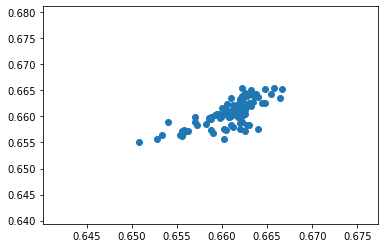

In [18]:
plt.scatter(tune_df['val_accuracy'], tune_df['test_accuracy'])

In [19]:
from scipy.stats import spearmanr

spearmanr(tune_df['val_accuracy'], tune_df['test_accuracy']).correlation

0.7093870733527099

Val performance and test performance are generally correlated...this is good!  Our results generalize!  We can get an extra half point of accuracy by just weighting the surfaces appropriately...We can take our optimal weights from above...

#### Let's Look at Best Model

In [20]:
BEST_WEIGHTS = {
    'Hard': 0.71,
    'Clay': 0.36,
    'Grass': 1.,
    'Carpet': 0.8
}

_weights = jd['tourney_surface'].map(lambda x: BEST_WEIGHTS[x])
best_elo = ELOModel(winner_mod=True)
best_elo.fit_and_backfill(
    jd['winner_name'].tolist(),
    jd['loser_name'].tolist(),
    jd['match_id'].tolist(),
    weights=_weights
)

In [24]:
# Get the last time each player played...
winner_deduped = jd.drop_duplicates('winner_name', keep='last').copy()
winner_deduped.rename(columns={'winner_name': 'player'}, inplace=True)

loser_deduped = jd.drop_duplicates('loser_name', keep='last').copy()
loser_deduped.rename(columns={'loser_name': 'player'}, inplace=True)

last_time_df = pd.merge(
    winner_deduped[['player', 'tourney_start_date']],
    loser_deduped[['player', 'tourney_start_date']],
    on='player',
    how='outer',
    suffixes=('_winner', '_loser')
)
last_time_df['max_date'] = last_time_df[['tourney_start_date_winner', 'tourney_start_date_loser']].max(axis=1)
last_play_dict = dict(zip(last_time_df['player'], last_time_df['max_date']))

In [25]:
cur_elo_ratings = pd.DataFrame(
    best_elo.beta.items(),
    columns=['player', 'ELO']
)
cur_elo_ratings['max_date'] = cur_elo_ratings['player'].map(lambda x: last_play_dict[x])
cur_elo_ratings[cur_elo_ratings['max_date'] >= '2018-01-01'].sort_values('ELO', ascending=False).head(30)

,player,ELO,max_date
8694,Novak Djokovic,2316.270406,2019-12-31
8331,Roger Federer,2295.218660,2019-06-17
8537,Rafael Nadal,2233.070649,2019-05-26
8726,Andy Murray,2198.364185,2019-12-31
8775,Juan Martin del Potro,2141.520016,2019-05-26
8954,Kei Nishikori,2073.595948,2019-12-31
9176,Kevin Anderson,2059.439358,2019-12-31
10094,Alexander Zverev,2037.789891,2019-06-17
10903,Stefanos Tsitsipas,2031.461304,2019-06-10
8747,Marin Cilic,2029.970049,2019-05-26


In [28]:
jd[jd['tourney_start_date'] == '2019-12-31'][[
    'tourney_start_date',
    'tourney_year',
    'tourney_month',
    'tourney_day',
    'tourney_name'
]]

,tourney_start_date,tourney_year,tourney_month,tourney_day,tourney_name
197986,2019-12-31,2019,12,31,Qatar ExxonMobil Open
197987,2019-12-31,2019,12,31,Brisbane International
197988,2019-12-31,2019,12,31,Tata Open Maharashtra
197989,2019-12-31,2019,12,31,Qatar ExxonMobil Open
197990,2019-12-31,2019,12,31,Brisbane International
197991,2019-12-31,2019,12,31,Tata Open Maharashtra
197992,2019-12-31,2019,12,31,Qatar ExxonMobil Open
197993,2019-12-31,2019,12,31,Brisbane International
197994,2019-12-31,2019,12,31,Tata Open Maharashtra
197995,2019-12-31,2019,12,31,Qatar ExxonMobil Open


#### Player Investigations

Some of these ratings don't quite make sense (they may be riding the high of their old selves...) Let's see what's going on with Andy Murray, for example

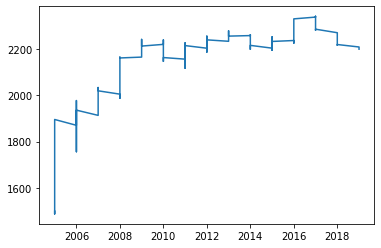

In [20]:
best_history_df = pd.DataFrame(best_elo.history)
jd_with_history = pd.merge(jd, best_history_df, on='match_id')

def plot_player_over_time(history_df, pid):
    rel = jd_with_history[
        (jd_with_history['p1_id'] == pid) | (jd_with_history['p2_id'] == pid)
    ]
    elos = rel[[
        'p1_id',
        'p2_id',
        'elo1',
        'elo2'
    ]].apply(
        lambda x: x['elo1'] if x['p1_id'] == pid else x['elo2'],
        axis=1
    )
    # plt.plot(range(len(elos)), elos)
    plt.plot(rel['tourney_start_date'], elos)
    # _x = np.array(range(0, len(elos), 50))
    # plt.xticks(
    #     _x.tolist(),
    #     rel['tourney_year'].iloc[_x].tolist(),
    #     rotation=90
    # )
    
plot_player_over_time(jd_with_history, 'Andy Murray')

In [21]:
def examine_player(player, last_n=20):
    return jd_with_history[
        (jd_with_history['winner_name'] == player) |
        (jd_with_history['loser_name'] == player)
    ].tail(last_n)[[
        'match_id',
        'tourney_year',
        'tourney_month',
        'tourney_day',
        'winner_name',
        'loser_name',
        'match_score_tiebreaks',
        'elo1',
        'elo2',
        'elo_match_prediction',
        'tourney_surface'
    ]]

examine_player("Andy Murray")

,match_id,tourney_year,tourney_month,tourney_day,winner_name,loser_name,match_score_tiebreaks,elo1,elo2,elo_match_prediction,tourney_surface
190694,2017-540-mc10-bk92,2017,7.0,3.0,Andy Murray,Alexander Bublik,61 64 62,2279.506522,1693.220920,0.966912,Grass
190758,2017-540-mc10-ba65,2017,7.0,3.0,Andy Murray,Dustin Brown,63 62 62,2280.071848,1793.656272,0.942678,Grass
190790,2017-540-mc10-f510,2017,7.0,3.0,Andy Murray,Fabio Fognini,62 46 61 75,2281.050749,1907.702572,0.895591,Grass
190806,2017-540-mc10-pd31,2017,7.0,3.0,Andy Murray,Benoit Paire,76(1) 64 64,2282.832889,1842.396261,0.926584,Grass
190814,2017-540-q927-mc10,2017,7.0,3.0,Sam Querrey,Andy Murray,36 64 67(4) 61 61,1918.620618,2284.085408,0.108730,Grass
194390,2018-311-ke17-mc10,2018,6.0,18.0,Nick Kyrgios,Andy Murray,26 76(4) 75,2034.633186,2268.887298,0.206120,Grass
194491,2018-741-mc10-w367,2018,6.0,25.0,Andy Murray,Stan Wawrinka,61 63,2255.356479,2007.157571,0.806706,Grass
194495,2018-741-e831-mc10,2018,6.0,25.0,Kyle Edmund,Andy Murray,64 64,1919.340900,2258.649363,0.124203,Grass
195033,2018-418-mc10-mk66,2018,7.0,30.0,Andy Murray,Mackenzie McDonald,36 64 75,2243.736830,1763.456208,0.940739,Hard
195047,2018-418-mc10-e831,2018,7.0,30.0,Andy Murray,Kyle Edmund,76(4) 16 64,2244.452914,1930.732778,0.858868,Hard


Seems like Murray is well on his way down, but because we've built up such a history in the past, we're not able to adjust for his injury fast enough.  The Glicko model may be a better way of going about this?  Something is also mislabeled, because our data indicates that Andy Murray has played a match in the future (on Dec 31, 2019)

In [21]:
def _find_player(p):
    _df = cur_elo_ratings[
        (cur_elo_ratings['player'].map(lambda x: p in x)) &
        (cur_elo_ratings['max_year'] > 2017.)
    ].sort_values('max_year', ascending=False)
    ret_player = _df['player'].iloc[0]
    if _df.shape[0] > 1:
        print("Found multiple players, returning %s..." % ret_player)
    return ret_player
        
def calculate_prob(p1, p2):
    p1_idx = _find_player(p1)
    p2_idx = _find_player(p2)
    prob = best_elo.predict(p1_idx, p2_idx)
    print(
        "{0} will defeat {1} with probability {2}, based on observing {3} matches for {0} and {4} matches for {1}".format(
            p1_idx,
            p2_idx,
            prob,
            best_elo.match_counts[p1_idx],
            best_elo.match_counts[p2_idx]
        )
    )
    print("{0} has ELO {1}".format(p1_idx, best_elo.beta[p1_idx]))
    print("{0} has ELO {1}".format(p2_idx, best_elo.beta[p2_idx]))

calculate_prob('Maceiras', 'Sela')

Adrian Menendez-Maceiras will defeat Dudi Sela with probability 0.26884660369373775, based on observing 170 matches for Adrian Menendez-Maceiras and 335 matches for Dudi Sela
Adrian Menendez-Maceiras has ELO 1607.4604930731437
Dudi Sela has ELO 1781.26207196637


In [22]:
cur_elo_ratings[cur_elo_ratings['player'].map(lambda x: 'Polmans' in x)].sort_values('max_year', ascending=False)

,player,ELO,max_year
10512,Marc Polmans,1472.676668,2019.0


In [23]:
cur_elo_ratings[cur_elo_ratings['player'].map(lambda x: 'Rosol' in x)]

,player,ELO,max_year
8859,Lukas Rosol,1694.941234,2019.0


In [24]:
best_elo.predict('Lukas Rosol', 'Guillermo Garcia-Lopez')

0.42427098764223514

In [25]:
best_elo.match_counts['Blaz Rola']

65

In [26]:
best_elo.match_counts['Daniel Brands']

303

In [27]:
jd[
    (jd['winner_name'] == 'Soonwoo Kwon') |
    (jd['loser_name'] == 'Soonwoo Kwon')
][[
    'winner_name',
    'loser_name',
    'tourney_name',
    'tourney_year',
    'tourney_month',
    'tourney_day'
]]

,winner_name,loser_name,tourney_name,tourney_year,tourney_month,tourney_day
187791,Vasek Pospisil,Soonwoo Kwon,Chengdu,2016,9,26
190353,Tatsuma Ito,Soonwoo Kwon,s-Hertogenbosch,2017,6,12
190630,Bradley Klahn,Soonwoo Kwon,Wimbledon,2017,7,3
191423,Nicolas Mahut,Soonwoo Kwon,US Open,2017,8,28
192277,Joao Souza,Soonwoo Kwon,Pune,2018,1,1
192605,Jan-Lennard Struff,Soonwoo Kwon,Australian Open,2018,1,15


This dude has played many more matches than this!  We will do much better if we can find them!  These matches are on the Challenger Tour, which is not represented in our current data

#### Aside, date writing

How do we read in dates appropriately with pandas csv reading?

In [33]:
from datetime import datetime

dates = jd.apply(
    lambda x: datetime(
        month=int(x['tourney_month']),
        year=int(x['tourney_year']),
        day=int(x['tourney_day'])
    ),
    axis=1
)

In [29]:
jd['date'] = pd.to_datetime(dates)

In [30]:
jd.to_csv('./date_test.csv', index=False)

In [31]:
q = pd.read_csv('./date_test.csv', parse_dates=['date'])

/Users/siddhantjagadish/Documents/DataProjects/tennis_new/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (7,8,13,33,39,40,41,42,43,44,45,46) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
